# MLMR2018 materials data science challenge
### Hydrogen storage alloy performance modeling
Organized by Brian DeCost, Jason Hattrick-Simpers, and A. Gilad Kusne (NIST)

To exercise the concepts covered in the MLMR workshop, we will be reproducing and extending the modeling work in this paper:

Hattrick-Simpers, Jason R., Kamal Choudhary, and Claudio Corgnale. *A simple constrained machine learning model for predicting high-pressure-hydrogen-compressor materials.* Molecular Systems Design & Engineering (**2018**) https://dx.doi.org/10.1039/C8ME00005K

This study uses ~400 unique alloys from the [IEA/DOE/SANDIA Hydride Databases](http://hydrogenmaterialssearch.govtools.us/) (the hydrogen storage materials database (HSMD)) to build models for the ethalpy (and entropy) of hydrogenation of potential hydrogen storage alloys. In addition to these alloys, we have reserved an independent test set of 50 alloys. You have access to the compositions and structures of these alloys, but we are witholding the enthalpies of hydrogenation until the end of the materials data science challenge.

The baseline model from the paper is random forest regression using the [magpie feature set](https://dx.doi.org/10.1038/npjcompumats.2016.28), evaluated with 10-fold cross-validation on these ~400 HSMD entries.

After reproducing the results of the paper, we offer several suggestions on how to dig deeper to improve the performance of your model, or to try to gain some insight into your model. After selecting and tuning your favorite machine learning model from the workshop using the HSMD entries, you can submit your predictions to the MLMR team for [kaggle](https://kaggle.com)-style evaluation.

### Starter code

This notebook contains starter code to load the HSMD data, filter and clean the entries, construct magpie features using [matminer](https://github.com/hackingmaterials/matminer), and fit a linear model using scikit-learn.

In [1]:
import sys
# !conda install --yes -c conda-forge opencv

In [2]:
# install pymatgen and matminer -- since they're not included in anaconda
import sys
# !{sys.executable} -m pip install pymatgen matminer
# Windows users: sorry! use conda
# conda install -c matsci pymatgen 
# conda install --yes -c conda-forge matminer

In [3]:
import re
import numpy as np
import pandas as pd
import pymatgen as mg

from sklearn import metrics
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection

import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

#### 0. Load the data!

In [4]:
# should not include the hold-out set... verify this.
df_full = pd.read_excel('data/Hydrogen Storage DataBase Full.xlsx')
df_full.sample(8)

,Material Class,Composition Formula,Hydrogen Weight Percent,Heat of Formation (kJ/mol H2),Temperature (˚C),Pressure (Atmospheres Absolute),Author Year,Reference Number,Comment1,Comment2,Comment3
127,A2B,Mg2Ni.75Fe.25,2.8,63.2,253,1,"Darnaudery, 1983",418,NaN,NaN,NaN
1373,AB5,NdNi4.9Sn.1,1.2,27.9,20,10,"Takaguchi, 2000",1196,NaN,NaN,NaN
286,AB,TiNi,1.2,NaN,NaN,NaN,"Reilly, 1966",489,NaN,NaN,NaN
1528,Complex,Rb3ZnH5,1.5,NaN,360,1,"Bortz, 1997",741,[ZnH4]2-,NaN,NaN
2298,MIC,Ti3Sb,0.8,110,NaN,NaN,"Rao, 1982",533,NaN,NaN,NaN
89,A2B,Mg1.75Ti.25Ni.75Cu.25,2.0,NaN,300,2.3,"Yuan, 1999",1229,NaN,NaN,NaN
1799,Mg,Mg12Nd,5.4,NaN,NaN,NaN,"Semenenko, 1985",1506,NaN,NaN,NaN
206,AB,TiFe.9Al.1,1.3,NaN,50,3,"Lee, 1999",1211,NaN,NaN,sloping plateau


In [5]:
df_full.groupby('Material Class').describe()

Hydrogen Weight Percent                                      \
                                 count      mean       std   min  25%  50%   
Material Class                                                               
A2B                              135.0  2.667778  7.244108  0.20  1.1  1.7   
AB                               157.0  1.351911  0.394996  0.20  1.1  1.4   
AB2                              586.0  1.482628  0.622257  0.00  1.2  1.5   
AB5                              438.0  1.141210  0.318543  0.14  0.9  1.2   
Complex                          233.0  4.581116  3.870922  0.40  1.8  3.2   
MIC                              428.0  1.247196  1.054957  0.00  0.5  1.1   
Mg                               362.0  3.739779  1.619165  0.00  2.6  3.6   
SS                               246.0  2.312154  5.905170  0.10  0.6  2.0   

                          Reference Number                                 \
                75%   max            count        mean         std    min   
Material Class                                                              
A2B             3.2  85.0            140.0  710.578571  472.017438    3.0   
AB              1.7   2.0            179.0  467.759777  388.869094   45.0   
AB2             1.8   5.4            625.0  573.505600  427.101622   13.0   
AB5             1.4   1.9            477.0  717.408805  514.529146   43.0   
Complex         5.9  20.8            234.0  942.299145  304.456915  331.0   
MIC             1.5  10.0            431.0  752.995360  451.631013   43.0   
Mg              5.1   7.4            373.0  935.474531  494.401031   45.0   
SS              3.4  92.1            263.0  844.923954  441.793381   84.0   

                                               
                  25%    50%      75%     max  
Material Class                                 
A2B             418.0  563.0  1225.25  1493.0  
AB               82.5  388.0   547.50  1230.0  
AB2             341.0  519.0   827.00  1294.0  
AB5             256.0  635.0  1196.00  1534.0  
Complex         747.0  776.5  1422.00  1463.0  
MIC             436.5  615.0  1309.00  1352.0  
Mg              576.0  714.0  1487.00  1507.0  
SS              471.0  629.0  1405.00  1421.0

In [6]:
# load the test set... note the missing enthalpy values!
df_test = pd.read_excel('data/test_set_jhs.xlsx')
df_test.head()

,comp,H2_wtpercent,Enthalpy,Temp_C,P_atm,Phase,Entropy (J/molK)
0,V0.85Ti0.1Fe0.05,1.5,NaN,100,53.14,AB2,NaN
1,Ti0.9Zr0.1Mn1.4Cr0.35V0.2Fe0.05,NaN,NaN,100,91.14,AB2,NaN
2,TiCr1.9,NaN,NaN,30,72.34,AB2,NaN
3,(Ti0.97Zr0.03)1.1Cr1.6Mn0.4,NaN,NaN,99,527.90,AB2,NaN
4,TiCr1.5Mn0.25Fe0.25,NaN,NaN,25,83.61,AB2,NaN


#### 1. Data cleaning: remove complex oxides, Mg, and references to Mm wt % and variable composition...
Data cleaning is one of the most important components of applying ML models to real-world data... We've done the task for you!

For this dataset, this amounts to writing regular expressions to filter out alloys with ill-defined compositions and calculating the mean value for entries reported as ranges.

This is more consistent and scalable than the manual filtering process used for the original paper, but frankly probably required more time....

![data cleaning](https://www.kdnuggets.com/images/cartoon-machine-learning-class.jpg)

In [7]:
# remove (M) from composition string...
pattern = re.compile(r'\s*\(M\)')
# e.g. pattern.sub('', 'LaCo4.95Mn.05 (M)')
remove_m = lambda x: pattern.sub('', x)

has_mg = lambda x: 'Mg' in x
variable_comp = lambda x: 'x' in x or '-' in x or '+' in x or ('y' in x and 'Dy' not in x)
has_mischmetal = lambda x: 'Mm' in x
has_mischmetal_pct = lambda x: 'wt.% Mm' in x or 'w/o Mm' in x or 'M?' in x
has_oxygen = lambda x: ('O' in x) and ('Os' not in x)

formula_has_R = lambda x: 'RNi' in x
formula_has_Lm = lambda x: 'Lm' in x

# match parentheses, with at least one comma
has_parens = lambda x: re.search(r'\((.*),+(.*)\)', x) is not None

# clean up composition string
df = df_full.copy()
new_comp = df['Composition Formula'].apply(remove_m)
df['Composition Formula'] = new_comp

# remove rows where material class is Complex or Mg
df = df[~df['Material Class'].isin(['Complex', 'Mg'])]
# df2 = df2[~df2['Composition Formula'].apply(has_mg)]

# throw out records with variable composition
df = df[~df['Composition Formula'].apply(variable_comp)]

# throw out records with references to mischmetal in wt. %
df = df[~df['Composition Formula'].apply(has_mischmetal_pct)]

# throw out records containing oxygen
df = df[~df['Composition Formula'].apply(has_oxygen)]

# throw out complex compounds (formula contains a comma-separated list...)
df = df[~df['Composition Formula'].apply(has_parens)]

# throw out records containing mischmetal...
df = df[~df['Composition Formula'].apply(has_mischmetal)]

# throw out records using R for mischmetal... specific to one author
df = df[~df['Composition Formula'].apply(formula_has_R)]

# throw out records using Lm for Lanthanum-rich mischmetal... 
df = df[~df['Composition Formula'].apply(formula_has_Lm)]

- There are a couple random datetime entries from https://doi.org/10.1016/S0925-8388(97)00592-6 and https://doi.org/10.1016/S0360-3199(00)00011-2, and appear to be Excel's fault in the original datasheet.
- Zr.2 Ho.8 CoFe should be '1 - 8' kJ/mol H2
- the other should be '-5 - -15' kJ/mol H2...

- the rest of the entries are just ranges that need to be averaged or something, or thrown out.

In [8]:
def average_range(x):
    """ find enthalpies reported as ranges and convert that entry to the average of the reported range """
    if type(x) is str and '-' in x:
        return np.mean(list(map(float, x.split(' - '))))
    else:
        return x
    
s = df['Heat of Formation (kJ/mol H2)'].apply(average_range)
df.loc[:,'Heat of Formation (kJ/mol H2)'] = s

In [9]:
def is_numeric(x):
    """ throw out any remaining datetime or string entries """
    try: 
        float(x); 
        return True; 
    except (TypeError, ValueError): 
        return False

df = df[df['Heat of Formation (kJ/mol H2)'].apply(is_numeric)]

In [10]:
df.sample(5)

,Material Class,Composition Formula,Hydrogen Weight Percent,Heat of Formation (kJ/mol H2),Temperature (˚C),Pressure (Atmospheres Absolute),Author Year,Reference Number,Comment1,Comment2,Comment3
893,AB2,ZrAl2,0.35,NaN,20,0.1,"Jacob, 1978",16,NaN,NaN,NaN
2679,SS,V.99Nb.01,3.50,NaN,40,4.3,"Yukawa, 2002",1411,NaN,NaN,NaN
57,A2B,Eu2Ir,1.00,NaN,NaN,NaN,"Moyer, 1980",457,NaN,NaN,NaN
2382,MIC,YFe3,1.90,NaN,NaN,NaN,"Buschow, 1976",685,NaN,NaN,NaN
1021,AB5,LaNi4.55Al.45,1.60,NaN,80,2,"Nakamura, 1994",590,NaN,NaN,NaN


In [11]:
(len(df_full)-len(df))/len(df_full)

0.3809698750918442

### 2. normalize composition strings
Just use pymatgen's composition parser -- it seems to work out of the box.

In [12]:
# throw out any rows with no heat of formation...
df = df[~pd.isna(df['Heat of Formation (kJ/mol H2)'])]

c = []
for idx, row in df.iterrows():
    c.append(mg.Composition(row['Composition Formula']))
    
df['composition'] = pd.Series(c, index=df.index)
df.head()

,Material Class,Composition Formula,Hydrogen Weight Percent,Heat of Formation (kJ/mol H2),Temperature (˚C),Pressure (Atmospheres Absolute),Author Year,Reference Number,Comment1,Comment2,Comment3,composition
3,A2B,Th1.5Ce.5Al,0.4,133,650,0.0003,"Van Vucht, 1963",492,NaN,NaN,NaN,"(Th, Ce, Al)"
4,A2B,Th2Al,0.8,130,500,0.001,"Van Vucht, 1963",492,NaN,NaN,NaN,"(Th, Al)"
17,A2B,Ti2Cu,2.2,130,500,0.12,"Kadel, 1978",523,NaN,NaN,NaN,"(Ti, Cu)"
29,A2B,Ti2Pd,1.4,90,NaN,NaN,"Kadel, 1978",523,NaN,NaN,NaN,"(Ti, Pd)"
37,A2B,Zr2Cu,1.3,144,600,0.003,"Pebler, 1966",12,NaN,NaN,NaN,"(Zr, Cu)"


In [48]:
df['Hf'] = df['Heat of Formation (kJ/mol H2)'].astype(float)

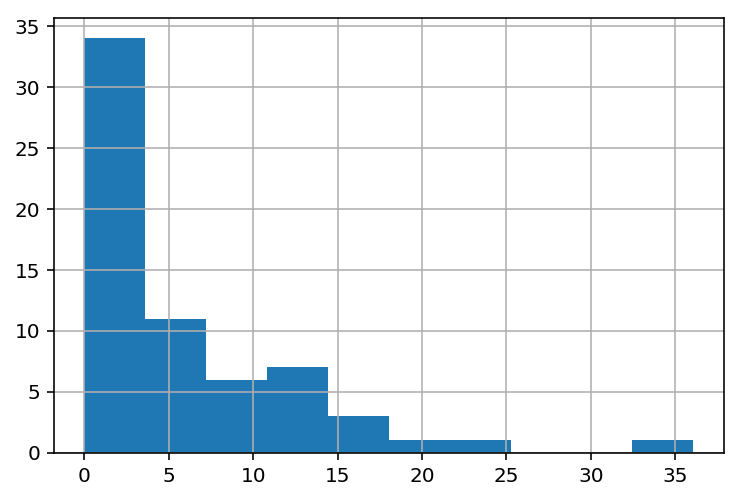

In [52]:
df.groupby('Composition Formula')['Hf'].describe()['std'].hist()

In [13]:
# now get compositions for the test set...
c_test = []
for idx, row in df_test.iterrows():
    c_test.append(mg.Composition(row['comp']))
    
df_test['composition'] = pd.Series(c_test, index=df_test.index)
df_test.head()

,comp,H2_wtpercent,Enthalpy,Temp_C,P_atm,Phase,Entropy (J/molK),composition
0,V0.85Ti0.1Fe0.05,1.5,NaN,100,53.14,AB2,NaN,"(V, Ti, Fe)"
1,Ti0.9Zr0.1Mn1.4Cr0.35V0.2Fe0.05,NaN,NaN,100,91.14,AB2,NaN,"(Ti, Zr, Mn, Cr, V, Fe)"
2,TiCr1.9,NaN,NaN,30,72.34,AB2,NaN,"(Ti, Cr)"
3,(Ti0.97Zr0.03)1.1Cr1.6Mn0.4,NaN,NaN,99,527.90,AB2,NaN,"(Ti, Zr, Cr, Mn)"
4,TiCr1.5Mn0.25Fe0.25,NaN,NaN,25,83.61,AB2,NaN,"(Ti, Cr, Mn, Fe)"


Look at the target distribution: (consider predicting the log of the enthalpy instead of the value, )

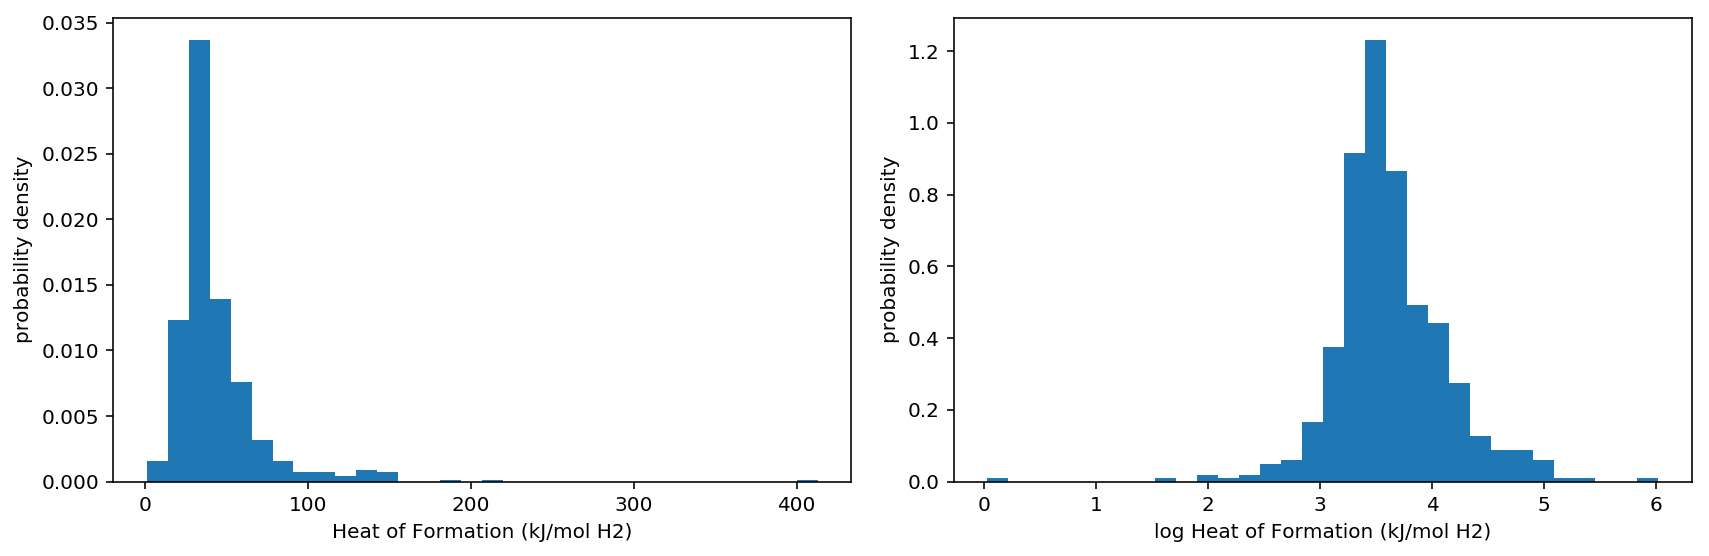

In [14]:
fig, (ax1, ax2) = plt.subplots(figsize=(12,4), ncols=2)
ax1.hist(df['Heat of Formation (kJ/mol H2)'].dropna().apply(float), bins=32, density=True);
ax1.set(xlabel='Heat of Formation (kJ/mol H2)', ylabel='probability density');

ax2.hist(np.log(df['Heat of Formation (kJ/mol H2)'].dropna().apply(float)), bins=32, density=True);
ax2.set(xlabel='log Heat of Formation (kJ/mol H2)', ylabel='probability density');

plt.tight_layout()

### 3. Finally, construct some (magpie) features and do some modeling

In [15]:
from matminer.featurizers import composition as composition_features

# use the standard magpie feature set...
# e.g. min, max, range, and mean for a collection of elemental properties (e.g. atomic number, covalent radius, space group number...)
f = composition_features.ElementProperty.from_preset('magpie')
X = f.featurize_dataframe(df, col_id='composition', inplace=False)
y = np.array(df['Heat of Formation (kJ/mol H2)'], dtype=float)

# matminer adds columns to the input dataframe... 
# so drop the original (metadata and target) columns from the new dataframe
n_metadata = len(df.keys())
X = X.iloc[:,n_metadata:]
X.head()

Widget Javascript not detected.  It may not be installed or enabled properly.


,minimum Number,maximum Number,range Number,mean Number,avg_dev Number,mode Number,minimum MendeleevNumber,maximum MendeleevNumber,range MendeleevNumber,mean MendeleevNumber,...,range GSmagmom,mean GSmagmom,avg_dev GSmagmom,mode GSmagmom,minimum SpaceGroupNumber,maximum SpaceGroupNumber,range SpaceGroupNumber,mean SpaceGroupNumber,avg_dev SpaceGroupNumber,mode SpaceGroupNumber
3,13.0,90.0,77.0,59.000000,31.000000,90.0,15.0,73.0,58.0,34.833333,...,0.000000,0.000000,0.00000,0.000000,194.0,225.0,31.0,219.833333,8.611111,225.0
4,13.0,90.0,77.0,64.333333,34.222222,90.0,16.0,73.0,57.0,35.000000,...,0.000000,0.000000,0.00000,0.000000,225.0,225.0,0.0,225.000000,0.000000,225.0
17,22.0,29.0,7.0,24.333333,3.111111,22.0,43.0,64.0,21.0,50.000000,...,0.000023,0.000015,0.00001,0.000023,194.0,225.0,31.0,204.333333,13.777778,194.0
29,22.0,46.0,24.0,30.000000,10.666667,22.0,43.0,62.0,19.0,49.333333,...,0.000023,0.000015,0.00001,0.000023,194.0,225.0,31.0,204.333333,13.777778,194.0
37,29.0,40.0,11.0,36.333333,4.888889,40.0,44.0,64.0,20.0,50.666667,...,0.000000,0.000000,0.00000,0.000000,194.0,225.0,31.0,204.333333,13.777778,194.0


In [16]:
# compute magpie features for the test set...
Xt = f.featurize_dataframe(df_test, col_id='composition', inplace=False)
n_metadata = len(df_test.keys())
Xt = Xt.iloc[:,n_metadata:]
Xt.head()

Widget Javascript not detected.  It may not be installed or enabled properly.


,minimum Number,maximum Number,range Number,mean Number,avg_dev Number,mode Number,minimum MendeleevNumber,maximum MendeleevNumber,range MendeleevNumber,mean MendeleevNumber,...,range GSmagmom,mean GSmagmom,avg_dev GSmagmom,mode GSmagmom,minimum SpaceGroupNumber,maximum SpaceGroupNumber,range SpaceGroupNumber,mean SpaceGroupNumber,avg_dev SpaceGroupNumber,mode SpaceGroupNumber
0,22.0,26.0,4.0,23.050000,0.295000,23.0,43.0,55.0,12.0,46.150000,...,2.110663,0.105535,0.200513,0.00000,194.0,229.0,35.0,225.500000,6.300000,229.0
1,22.0,40.0,18.0,24.366667,1.687778,25.0,43.0,55.0,12.0,48.333333,...,2.110663,0.035329,0.069178,0.00031,194.0,229.0,35.0,211.733333,11.822222,217.0
2,22.0,24.0,2.0,23.310345,0.903686,24.0,43.0,49.0,6.0,46.931034,...,0.000023,0.000008,0.000010,0.00000,194.0,229.0,35.0,216.931034,15.814507,229.0
3,22.0,40.0,18.0,23.610968,1.108969,24.0,43.0,52.0,9.0,47.268710,...,0.000310,0.000048,0.000068,0.00000,194.0,229.0,35.0,215.032258,14.926119,229.0
4,22.0,26.0,4.0,23.583333,1.055556,24.0,43.0,55.0,12.0,47.750000,...,2.110663,0.175922,0.322457,0.00000,194.0,229.0,35.0,216.333333,14.888889,229.0


In [17]:
# naive train/val split, without consideration of duplicate compositions

y = np.array(df['Heat of Formation (kJ/mol H2)'], dtype=float)
X_train, X_val, y_train, y_val = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

# standardize the input features for linear regression
# skip this for e.g. random forest...
std = preprocessing.StandardScaler()
std.fit(X_train)
X_train, X_val, X_test = std.transform(X_train), std.transform(X_val), std.transform(Xt)

/anaconda/envs/pyten/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning:

internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.



train: 7.691262958654631 kJ/mol
val: 19.897234707636418 kJ/mol


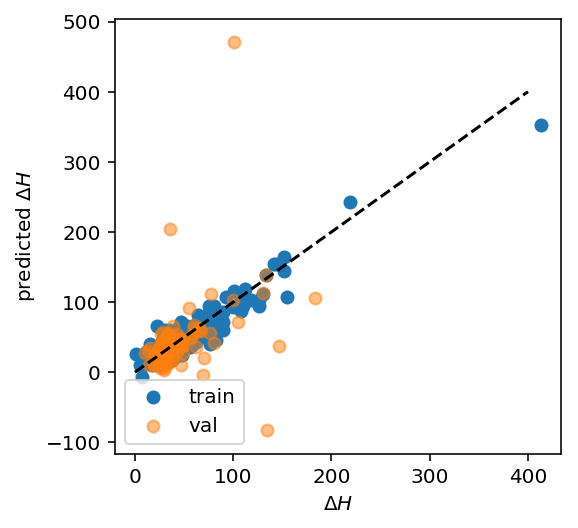

In [18]:
fig, ax = plt.subplots(figsize=(4,4))

model = linear_model.LinearRegression()

model.fit(X_train, y_train)
ax.scatter(y_train, model.predict(X_train), label='train')
ax.scatter(y_val, model.predict(X_val), label='val', alpha=0.5)
ax.plot((0,400), (0,400), linestyle='--', color='k')

ax.set(xlabel=r'$\Delta H$', ylabel = r'predicted $\Delta H$');
ax.legend()

print('train:', metrics.mean_absolute_error(y_train, model.predict(X_train)), 'kJ/mol')
print('val:', metrics.mean_absolute_error(y_val, model.predict(X_val)), 'kJ/mol')

In [22]:
# print out (and save) test set predictions
pred_test = model.predict(X_test)

with open('hydride_test_set_predictions.txt', 'w') as textfile:
    for idx, row in df_test.iterrows():
        print('{}, {}'.format(row.comp, pred_test[idx]))
        print('{}, {}'.format(row.comp, pred_test[idx]), file=textfile)

V0.85Ti0.1Fe0.05, 39.74480657719256
Ti0.9Zr0.1Mn1.4Cr0.35V0.2Fe0.05, 34.26922063969256
TiCr1.9, 19.812189389692563
(Ti0.97Zr0.03)1.1Cr1.6Mn0.4, 35.06511907719256
TiCr1.5Mn0.25Fe0.25, 37.98699407719256
TiCr1.5Mn0.2Fe0.3, 36.70672063969256
TiCrMn, 10.903009702192563
(Ti0.8Zr0.2)1.1CrMn, 10.008478452192563
TiFe, 38.30925970219256
TiMn1.5, 36.26433782719256
TiCr1.75Al0.05, 40.65203313969256
TiCr1.7Al0.2, 34.60613470219256
TiCr1.6Mn0.2, 33.71160345219256
TiCr0.95Mn0.95, 26.143244077192563
TiCr1.75Ni0.1, 28.356134702192563
TiCr1.7Ni0.3, 27.803400327192563
TiCr1.9Mo0.01, 41.19597845219256
Ti1.1CrMn, 27.890314389692563
(Ti0.85Zr0.15)1.1CrMn, 9.202814389692563
(Ti0.85Zr0.15)1.1Cr0.95Mo0.05Mn, 37.54656438969256
(Ti0.85Zr0.15)1.1Cr0.9Mo0.1Mn, 36.91179876469256
(Ti0.85Zr0.15)1.1Cr0.85Mo0.15Mn, 36.53972845219256
(Ti0.85Zr0.15)1.1Cr0.98W0.02Mn, 24.593439389692563
(Ti0.85Zr0.15)1.1Cr0.95W0.05Mn, 24.856134702192563
(Ti0.85Zr0.15)1.1Cr0.9W0.1Mn, 25.312189389692563
TiCr1.6Mn0.2Fe0.2, 37.44695501469256
T

### 4. Baseline challenge

Random forest regression using magpie features. (**Don't apply standardization** -- this typically isn't necessary for tree-based models).

#### reproduce Jae's results with 10-fold randomized CV (on the training set)
- compare your 10-fold cross-validation performance with the paper
- save your predictions on the independent test set -- we'll evaluate them at the end of the challenge!
- can you do a feature importance analysis? What's features are important for these hydride materials?
- justify/interpret the model performance

In [54]:
# Random forest modeling and evaluation here...
from sklearn import ensemble

# try to match Weka defaults...
model = ensemble.RandomForestRegressor(n_estimators=100, max_features='log2')
cv_pred = model_selection.cross_val_predict(model, X, y, cv=10, verbose=True)

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.0s finished


In [63]:
model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

val: 12.229735795349589 kJ/mol


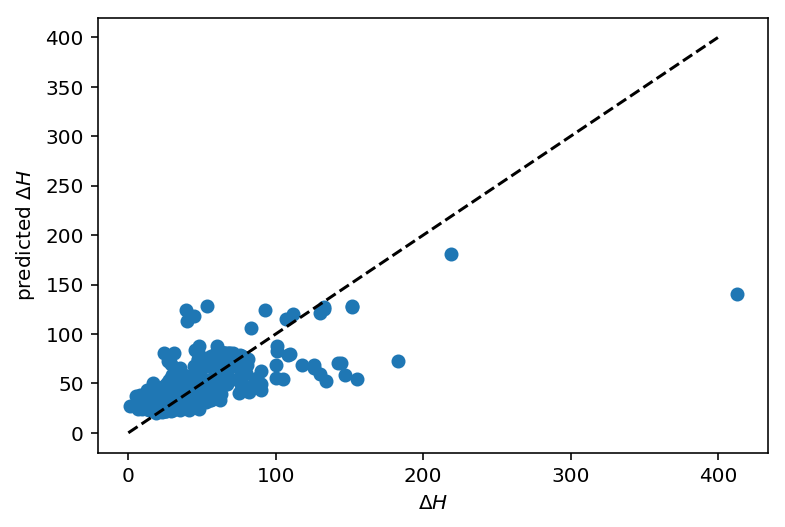

In [27]:
plt.scatter(y, cv_pred)
plt.plot((0,400), (0,400), linestyle='--', color='k')

plt.xlabel(r'$\Delta H$')
plt.ylabel(r'predicted $\Delta H$')

print('val:', metrics.mean_absolute_error(y, cv_pred), 'kJ/mol')

# print('train:', metrics.mean_absolute_error(y_train, model.predict(X_train)), 'kJ/mol')
# print('val:', metrics.mean_absolute_error(y_val, model.predict(X_val)), 'kJ/mol')

In [30]:
model_selection.cross_val_predict

<function sklearn.model_selection._validation.cross_val_predict>

/anaconda/envs/pyten/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/anaconda/envs/pyten/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/anaconda/envs/pyten/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/anaconda/envs/pyten/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fittin

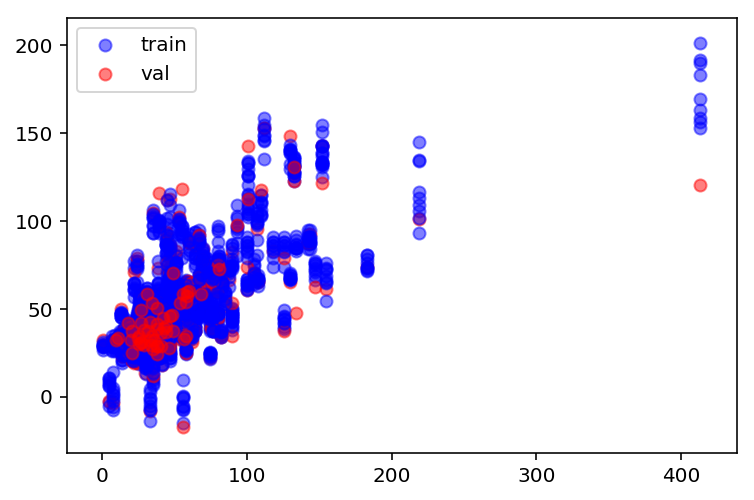

In [31]:
# Random forest modeling and evaluation here...

from scipy import stats
from sklearn import ensemble
from collections import defaultdict

cv = model_selection.KFold(n_splits=10, shuffle=True)
inner_cv = model_selection.KFold(n_splits=10, shuffle=True)
# try to match Weka defaults...
# model = ensemble.RandomForestRegressor(n_estimators=100, max_features='log2')
# model = linear_model.BayesianRidge()
# model = linear_model.LassoCV(cv=inner_cv, max_iter=200)
model = linear_model.ElasticNetCV(cv=inner_cv, max_iter=200)

score = {
    'train': defaultdict(list),
    'val': defaultdict(list)
}

for idx, (train, val) in enumerate(cv.split(X)):
    model.fit(X.iloc[train], y[train])
    
    if idx == 0:
        label = ('train', 'val')
    else:
        label = (None, None)
        
    plt.scatter(y[train], model.predict(X.iloc[train]), c='b', alpha=0.5, label=label[0])
    plt.scatter(y[val], model.predict(X.iloc[val]), c='r', alpha=0.5, label=label[1])
    
    # MAE
    score['train']['mae'].append(metrics.mean_absolute_error(y[train], model.predict(X.iloc[train])))
    score['val']['mae'].append(metrics.mean_absolute_error(y[val], model.predict(X.iloc[val])))
    
    # pearson -- print just the coefficient; throw away the p-value
    score['train']['pearson'].append(stats.pearsonr(y[train], model.predict(X.iloc[train]))[0])
    score['val']['pearson'].append(stats.pearsonr(y[val], model.predict(X.iloc[val]))[0])
    
    # spearman -- print just the coefficient; throw away the p-value
    score['train']['spearman'].append(stats.spearmanr(y[train], model.predict(X.iloc[train]))[0])
    score['val']['spearman'].append(stats.spearmanr(y[val], model.predict(X.iloc[val]))[0])
    
plt.legend();

In [32]:
# print mean CV performance with standard errors
for metric in ('mae', 'pearson', 'spearman'):
    print(metric, np.mean(score['train'][metric]), '+/-', stats.sem(score['train'][metric]))
    print(metric, np.mean(score['val'][metric]), '+/-', stats.sem(score['val'][metric]))
    print()

mae 10.93151519860691 +/- 0.17390129376758826
mae 12.191851318592846 +/- 0.7387095039836332

pearson 0.7466716475434315 +/- 0.006657913944361779
pearson 0.6816964418556297 +/- 0.04060416329782649

spearman 0.66922699980072 +/- 0.010310805183640515
spearman 0.630157440491371 +/- 0.027103905095427483



In [33]:
# LassoCV
# print mean CV performance with standard errors
for metric in ('mae', 'pearson', 'spearman'):
    print(metric, np.mean(score['train'][metric]), '+/-', stats.sem(score['train'][metric]))
    print(metric, np.mean(score['val'][metric]), '+/-', stats.sem(score['val'][metric]))
    print()

mae 10.93151519860691 +/- 0.17390129376758826
mae 12.191851318592846 +/- 0.7387095039836332

pearson 0.7466716475434315 +/- 0.006657913944361779
pearson 0.6816964418556297 +/- 0.04060416329782649

spearman 0.66922699980072 +/- 0.010310805183640515
spearman 0.630157440491371 +/- 0.027103905095427483



In [34]:
# ElasticNetCV
# print mean CV performance with standard errors
for metric in ('mae', 'pearson', 'spearman'):
    print(metric, np.mean(score['train'][metric]), '+/-', stats.sem(score['train'][metric]))
    print(metric, np.mean(score['val'][metric]), '+/-', stats.sem(score['val'][metric]))
    print()

mae 10.93151519860691 +/- 0.17390129376758826
mae 12.191851318592846 +/- 0.7387095039836332

pearson 0.7466716475434315 +/- 0.006657913944361779
pearson 0.6816964418556297 +/- 0.04060416329782649

spearman 0.66922699980072 +/- 0.010310805183640515
spearman 0.630157440491371 +/- 0.027103905095427483



In [35]:
# print mean CV performance with standard errors
for metric in ('mae', 'pearson', 'spearman'):
    print(metric, np.mean(score['train'][metric]), '+/-', stats.sem(score['train'][metric]))
    print(metric, np.mean(score['val'][metric]), '+/-', stats.sem(score['val'][metric]))
    print()

mae 10.93151519860691 +/- 0.17390129376758826
mae 12.191851318592846 +/- 0.7387095039836332

pearson 0.7466716475434315 +/- 0.006657913944361779
pearson 0.6816964418556297 +/- 0.04060416329782649

spearman 0.66922699980072 +/- 0.010310805183640515
spearman 0.630157440491371 +/- 0.027103905095427483



### 5. Digging deeper

Here are some primer questions to inspire you. These suggestions are roughly ordered according to how deep we think you'll need to dig in order to answer them.

Save your predictions for the independent test set from your favorite model -- we'll evaluate them at the end of the challenge!

#### Is linear regression better than (or as good as) random forest?
Can you train a regularized linear model that is better (or as good as) the RF model?

(Hint: make sure you re-compute the standardization on just the training set for each validation fold -- look into scikit-learn pipelines)

#### Do solid-solution compounds help?
There are no solid solutions in the hold-out set.... Does it help or hurt to include them in the training set?

#### Does it help to add structural information?
- Does it help to add structural information to your model? (e.g. the 'Material Class' column)
- What about training separate models for each different structure class?

#### Dealing with duplicate and near-duplicate compositions
There are a non-trivial number of  duplicate and near-duplicate compositions in the dataset -- with the randomized cross-validation procedure we've been using, it's possible that the same composition shows up in both training and validation sets.
- Does this significantly bias the estimated generalization performance? (To address this question, you might find helpful the example code on creating fair train/val splits at the end of the notebook.)

#### Model selection
Choose your favorite model from the MLMR workshop and do some hyperparameter tuning. Can you get better predictive performance?

#### Feature engineering
Magpie includes a diverse set of numerical and categorical properties of the elements. Some of the features in the magpie feature set may be more relevant than others to predicting the quality of hydrogen storage materials. (Consider e.g. the composition-averaged space group number....)
- can you train a model (need not be a random forest) with competetive performance using a hand-picked or automatically selected subset of magpie features?
- Consider using alternative features. (Check out some of the other feature sets available in [matminer](https://github.com/hackingmaterials/matminer), or come up with your own)

In [17]:
# further analysis here...


#### Example code for fair train/val splitting

In [17]:
# do a fair train/val split by splitting out unique compositions together, so that no unique composition shows up in both train and val
compositions = df.composition.apply(str).unique()
C_train, C_test = model_selection.train_test_split(compositions, test_size=0.25, random_state=42)

X_train = X[df.composition.apply(str).isin(C_train)]
y_train = y[df.composition.apply(str).isin(C_train)]

X_test = X[df.composition.apply(str).isin(C_test)]
y_test = y[df.composition.apply(str).isin(C_test)]

# standardize the input features for linear regression
# can skip this for e.g. random forest...
std = preprocessing.StandardScaler()
std.fit(X_train)
X_train, X_test = std.transform(X_train), std.transform(X_test)

In [18]:
# instead, do a fair train/val split by splitting out nearly-unique compositions separately
# this should split compounds up by considering only their constituent elements
compositions = df.composition.unique()
C_train, C_test = model_selection.train_test_split(compositions, test_size=0.25, random_state=42)

X_train = X[df.composition.isin(C_train)]
y_train = y[df.composition.isin(C_train)]

X_test = X[df.composition.isin(C_test)]
y_test = y[df.composition.isin(C_test)]

# standardize the input features for linear regression
# can skip this for e.g. random forest...
std = preprocessing.StandardScaler()
std.fit(X_train)
X_train, X_test = std.transform(X_train), std.transform(X_test)